In [1]:
import importlib
import os
import sys

import numpy as np
import torch
from torchinfo import summary

In [2]:
############## Import modules ##############
sys.path.append('../')

%load_ext autoreload
%autoreload 2

from modules.attributions import plotter
from modules.attributions.attribution_comparer import AttributionComparer, gather_all_attrs, shorten_attr_names
from modules.attributions.attribution_config import config as default_attr_config
from modules.attributions.attribution_processor import ClassificationProcessor
from modules.datasets import dataset_utils, pkl_loader, ucr_loader
from modules.networks import model_utils
from modules.networks.model import FCN, FDN, LSTM, AlexNet, Inception
from modules.utils import mean_cr_utils, utils

/home/mercier/bin/anaconda3/envs/python38/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10002. The TBB threading layer is disabled.
  warnings.warn(problem)


In [3]:
class OptionParser:
    def __init__(self):
        ########## Global settings #############
        self.verbose = False
        self.seed = 0
        ######### Dataset processing ###########
        self.root_path = "../../data/"
        self.dataset_name =  "ElectricDevices"
        self.dataset_file = "dataset.pickle"
        self.normalize = False
        self.standardize = False
        self.validation_split = 0.3
        self.is_channel_first = False
        ######## Dataset modifications #########
        self.randomize_labels = False
        self.use_subset = False
        self.subset_factor = 100
        ######### Experiment details ###########
        self.runs = 1
        self.exp_path = None
        self.architecture = "AlexNet"
        ####### Perform baseline model #########
        self.load_model = False
        self.save_model = False
        self.epochs = 100
        self.batch_size = 32
        ########## Model modifications #########
        self.randomize_model = False
        self.randomize_top_down = False
        self.ranomize_n_layers = None
        self.randomize_ids = 1
        ############# Evaluation ###############
        self.save_report = False
        self.save_mcr = False
        ########## Evaluation subset ###########
        self.evaluate_subset = False
        self.save_subset_report = False
        ############ Save details ##############
        self.plot_index = 0
        self.save_dicts = False
        self.save_plots = False
        self.not_show_plots = False
        ########## Attribution details #########
        self.process_attributions = False
        self.not_save_attributions = False
        self.attr_config = None
        self.compute_attributions = False
        self.plot_attributions = False
        self.attr_name = "default"
        self.save_memory = False
        ########### Compute Sensitivity ########
        self.compute_sensitivity = False
        self.sensitivity_scale = 0.02
        ############## Compute Time ############
        self.compute_time = False
        ######### Attribution comparison #######
        self.create_comparer = False
        self.comparer_exp_names = None
        self.comparer_architectures = None
        self.comparer_attr_paths = None
        self.comparer_attr_names = None
        self.comparer_exclude = None
        ########### Plot comparer grid #########
        self.plot_comparer_sample = False
        ########### Compute Continuity #########
        self.compute_continuity = False
        ########### Compute correlation ########
        self.compute_correlation = False
        self.correlations = "pearsonr,speamanr,jaccard"
        self.correlation_perc = "10,20,100"
        ########## Compute modified accs #######
        self.compute_modified_accs = False
        self.modified_accs_perc = 95
        self.modified_accs_keep_smaller = 1
        ########### Compute infidelity #########
        self.compute_infidelity = False
        self.infidelity_scale = 0.2
        ####### Compute correlation matrix #####
        self.compute_correlation_mat = False
        ######### Compute modified_dict ########
        self.compute_modified_acc_dict = False
        self.compute_modified_acc_dict_ranges ="0,105,5,0,105,5"
        ######## Compute required ratios #######
        self.compute_agreements = False
        self.agreement_percs = "90,105,5"

options = OptionParser()

In [4]:
########## Customize setting ###########
if 1:
    options.verbose = True
    options.dataset_name = 'CharacterTrajectories'
    options.exp_path = 'baseline_inception'
    options.standardize = True
    options.use_subset = True
    options.subset_factor = 100
    options.load_model = True
    options.save_model = True
    options.evaluate_subset = True
    options.attr_name = '100'
    options.process_attributions = True
    options.compute_attributions = True
    options.plot_attributions = True
    options.architecture = 'Inception'
if 0:
    options.verbose = True
    options.dataset_name = 'CharacterTrajectories'
    options.exp_path = 'baseline'
    options.standardize = True
    options.use_subset = True
    options.subset_factor = 100
    options.load_model = True
    options.evaluate_subset = True
    options.save_subset_report = True
    options.comparer_exp_names = ['baseline', 'randomized_data']
    options.create_comparer = True
    options.save_dicts = True
    options.save_plots = True
    options.compute_sensitivity = True
    options.compute_time = True
    options.plot_comparer_sample = True
    options.compute_continuity = True
    options.compute_correlation = True
    options.compute_modified_accs = True
    options.compute_infidelity = True
    options.compute_correlation_mat = True
    options.compute_modified_acc_dict = True
    options.compute_agreements = True
if 0:
    options.verbose = True
    options.dataset_name = 'anomaly_new'
    options.exp_path = 'test'
    options.standardize = True
    options.use_subset = True
    options.subset_factor = 100
    options.load_model = True
    options.comparer_exp_names = ['baseline', 'randomized_data']
    options.create_comparer = True
    options.save_plots = True

In [5]:
########## Global settings #############
np.random.seed(options.seed)
torch.manual_seed(options.seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_dir, result_dir = utils.maybe_create_dirs(
    options.dataset_name, root='../../', dirs=['models', 'results'], exp=options.exp_path, return_paths=True, verbose=options.verbose)

Created directory: ../../models/baseline_inception/CharacterTrajectories
Created directory: ../../results/baseline_inception/CharacterTrajectories


In [6]:
######### Dataset processing ###########
dataset_dict = ucr_loader.get_datasets(options.root_path, prefix='**/')
split_id = None
try:
    trainX, trainY, testX, testY = ucr_loader.load_data(
        dataset_dict[options.dataset_name])
    valX, valY = None, None
except:
    trainX, trainY, valX, valY, testX, testY = pkl_loader.load_data(os.path.join(
        options.root_path, options.dataset_name, options.dataset_file), is_channel_first=options.is_channel_first)
if valX is not None:
    trainX, trainY, split_id = dataset_utils.fuse_train_val(
        trainX, trainY, valX, valY)
trainX, trainY, testX, testY = dataset_utils.preprocess_data(
    trainX, trainY, testX, testY, normalize=options.normalize, standardize=options.standardize, channel_first=True)
if split_id is None:
    trainX, trainY, valX, valY = dataset_utils.perform_datasplit(
        trainX, trainY, test_split=options.validation_split)
else:
    trainX, trainY, valX, valY = dataset_utils.unfuse_train_val(
        trainX, trainY, split_id)
channels, timesteps = trainX.shape[1:]
n_classes = len(np.unique(trainY))

if options.verbose:
    print('TrainX:', trainX.shape)
    print('ValX:', valX.shape)
    print('TestX:', testX.shape)
    print('Classes:', n_classes)

TrainX: (995, 3, 182)
ValX: (427, 3, 182)
TestX: (1436, 3, 182)
Classes: 20


In [7]:
##### Subset creation for attr #########
if options.use_subset:
    sub_testX, sub_testY, sub_ids = dataset_utils.select_subset(
        testX, testY, options.subset_factor)
else:
    sub_testX, sub_testY, sub_ids = testX, testY, np.arange(
        testX.shape[0])

In [8]:
######## Label randomization ###########
if options.randomize_labels:
    if options.verbose:
        print('Randomized Train labels and set val to train')
    trainY = dataset_utils.randomize_labels(trainY)
    valX, valY = trainX, trainY

In [9]:
######### Data loader creation #########
trainloader = model_utils.create_dataloader(
    trainX, trainY, batch_size=options.batch_size, shuffle=True, drop_last=False, num_workers=8)
valloader = model_utils.create_dataloader(
    valX, valY, batch_size=options.batch_size, shuffle=False, drop_last=False, num_workers=8)

In [10]:
######### Model architecture ###########
architecture_func = {'AlexNet': AlexNet,
                        'FCN': FCN, 'FDN': FDN, 'LSTM': LSTM,
                        'Inception': Inception}

In [11]:
########## Run wise processing #########
report_paths = []
# commented out due to no run processing in notebook
# for i in range(options.runs):
run_id = 0  # global run
if options.verbose:
    print('Run %d / %d' % (run_id+1, options.runs))
####### Perform baseline model #########
model_setup = options.architecture + '_batch-' + \
    str(options.batch_size) + '_run-' + str(run_id)
model_setup_backup = model_setup
model_path = os.path.join(
    model_dir, model_setup + '.pt') if options.save_model or options.load_model else None

model = architecture_func[options.architecture](
    timesteps, channels, n_classes).to(device)
if options.verbose:
    summary(model, input_size=(
        options.batch_size, channels, timesteps))
    pass

if os.path.exists(model_path) and options.load_model:
    model.load_state_dict(torch.load(model_path))
else:
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.01, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor=0.5, patience=5, verbose=options.verbose)

    model_utils.train(model, trainloader, valloader, options.epochs, optimizer, criterion,
                        lr_scheduler=scheduler, early_patience=10, path=model_path, verbose=options.verbose)
model.eval()

Run 1 / 1
Epoch: 1/100 | Loss: 1.5451 | Accuracy: 46.93 % | ValLoss: 26.4153 | ValAccuracy: 74.71 %
Epoch: 2/100 | Loss: 0.1970 | Accuracy: 87.04 % | ValLoss: 6.0495 | ValAccuracy: 96.25 %
Epoch: 3/100 | Loss: 0.2533 | Accuracy: 94.77 % | ValLoss: 4.5179 | ValAccuracy: 91.33 %
Epoch: 4/100 | Loss: 0.0661 | Accuracy: 97.19 % | ValLoss: 3.3972 | ValAccuracy: 93.91 %
Epoch: 5/100 | Loss: 0.0824 | Accuracy: 97.39 % | ValLoss: 1.9368 | ValAccuracy: 97.19 %
Epoch: 6/100 | Loss: 0.0180 | Accuracy: 97.19 % | ValLoss: 1.2338 | ValAccuracy: 98.36 %
Epoch: 7/100 | Loss: 0.0221 | Accuracy: 98.59 % | ValLoss: 1.0521 | ValAccuracy: 98.36 %
Epoch: 8/100 | Loss: 0.0199 | Accuracy: 99.20 % | ValLoss: 2.4252 | ValAccuracy: 93.91 %
Epoch: 9/100 | Loss: 0.0199 | Accuracy: 98.69 % | ValLoss: 2.1617 | ValAccuracy: 95.55 %
Epoch: 10/100 | Loss: 0.0229 | Accuracy: 98.49 % | ValLoss: 1.2644 | ValAccuracy: 97.66 %
Epoch: 11/100 | Loss: 0.0099 | Accuracy: 98.79 % | ValLoss: 1.5601 | ValAccuracy: 96.96 %
Epoch: 1

Inception(
  (inceptionblock): InceptionBlock(
    (inception): ModuleList(
      (0): InceptionModule(
        (bottleneck): Conv1d(3, 32, kernel_size=(1,), stride=(1,), bias=False)
        (convs): ModuleList(
          (0): Conv1d(32, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
          (1): Conv1d(32, 32, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
          (2): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
        )
        (maxconvpool): Sequential(
          (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
          (1): Conv1d(3, 32, kernel_size=(1,), stride=(1,), bias=False)
        )
        (concat): Concat(dim=1)
        (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU()
      )
      (1): InceptionModule(
        (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,), bias=False)
        (convs): ModuleList(
          (0

In [12]:
######## Randomized modificaiton #######
if options.randomize_model:
    layer_ids = np.fromstring(
        options.randomize_ids, dtype=int, sep=',')
    model = model_utils.randomize_layers(model, layer_ids=layer_ids, n_layers=options.randomize_n_layers,
                                            top_down=options.randomize_top_down, verbose=options.verbose)

    model_setup = model_utils.get_randomized_path(model_setup_backup, layer_ids=options.randomize_ids, n_layers=options.randomize_n_layers,
                                                    top_down=options.randomize_top_down)

In [13]:
############# Evaluation ###############
report_path = os.path.join(
    result_dir, model_setup + '_report.txt') if options.save_report or options.save_mcr else None
outs = model(torch.Tensor(testX).to(device)).detach().to('cpu')
preds = torch.argmax(outs, dim=1).numpy()
utils.compute_classification_report(
    testY, preds, save=report_path, verbose=options.verbose, store_dict=True)
if report_path is not None:
    report_paths.append(report_path.replace('.txt', '.pickle'))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        86
           1     0.9559    1.0000    0.9774        65
           2     1.0000    1.0000    1.0000        71
           3     1.0000    1.0000    1.0000        66
           4     1.0000    1.0000    1.0000        62
           5     1.0000    0.9833    0.9916        60
           6     1.0000    1.0000    1.0000        67
           7     0.9706    1.0000    0.9851        66
           8     0.9873    1.0000    0.9936        78
           9     1.0000    0.9524    0.9756        63
          10     1.0000    1.0000    1.0000        69
          11     1.0000    1.0000    1.0000        71
          12     1.0000    1.0000    1.0000        86
          13     1.0000    1.0000    1.0000        71
          14     1.0000    1.0000    1.0000        79
          15     1.0000    1.0000    1.0000        93
          16     1.0000    1.0000    1.0000        69
          17     1.0000    

In [14]:
############ Evaluate subset ###########
if options.evaluate_subset or options.create_comparer:
    if options.use_subset:
        subset_folder = os.path.join(
            result_dir, model_setup, 'subset_' + str(options.subset_factor))
    else:
        subset_folder = os.path.join(
            result_dir, model_setup, 'complete')
    os.makedirs(subset_folder, exist_ok=True)
    subset_report_path = os.path.join(subset_folder, 'acc_report.txt') \
        if options.save_subset_report else None
    outs = model(torch.Tensor(sub_testX).to(device)).detach().cpu()
    preds = torch.argmax(outs, dim=1).numpy()
    utils.compute_classification_report(
        sub_testY, preds, save=subset_report_path, verbose=options.verbose, store_dict=True)

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         6
           1     1.0000    1.0000    1.0000         5
           2     1.0000    1.0000    1.0000         5
           3     1.0000    1.0000    1.0000         5
           4     1.0000    1.0000    1.0000         4
           5     1.0000    1.0000    1.0000         4
           6     1.0000    1.0000    1.0000         5
           7     1.0000    1.0000    1.0000         5
           8     1.0000    1.0000    1.0000         5
           9     1.0000    1.0000    1.0000         4
          10     1.0000    1.0000    1.0000         5
          11     1.0000    1.0000    1.0000         5
          12     1.0000    1.0000    1.0000         6
          13     1.0000    1.0000    1.0000         5
          14     1.0000    1.0000    1.0000         6
          15     1.0000    1.0000    1.0000         6
          16     1.0000    1.0000    1.0000         5
          17     1.0000    

In [15]:
######### Attribution ##################
from modules.attributions.attribution_config_dev import config as default_attr_config

if options.process_attributions:
    config_file = default_attr_config
    if options.attr_config is not None:
        config_spec = importlib.util.spec_from_file_location(
        "attr_config", options.attr_config)
        config_mod = importlib.util.module_from_spec(config_spec)
        config_spec.loader.exec_module(config_mod)
        config_file = config_mod.config
    attr_dir = None
    if not options.not_save_attributions:
        attr_dir = os.path.join(
            model_dir, model_setup, options.attr_name)
        os.makedirs(attr_dir, exist_ok=True)
        if options.use_subset:
            np.save(os.path.join(attr_dir, 'Sub_ids.npy'), sub_ids)
    attrProcessor = ClassificationProcessor(
        model, trainX.shape[1:], config_file, save_memory=options.save_memory, attr_dir=attr_dir, 
        load=not options.compute_attributions, verbose=options.verbose)

    if options.compute_attributions:
        if options.verbose:
            print('Use %s samples for attribution' % sub_ids.shape[0])
        attrProcessor.process_attributions(
            sub_testX, sub_testY, attr_dir)

    if options.plot_attributions:
        attrProcessor.plot_approaches(
            sub_testX, index=options.plot_index, not_show=options.not_show_plots, save_path=subset_folder if options.save_plots else None)

Prepared: Deconvolution...DeepLift...DeepLiftShap...Dynamask...FeatureAblation...FeaturePermutation...GradientShap...GuidedBackprop...InputXGradient...IntegratedGradients...KernelShap...LRP...Lime...Occlusion...RISE...Saliency...ShapleyValueSampling...Timereise...Done
Use 96 samples for attribution


RuntimeError: you can only change requires_grad flags of leaf variables.

In [16]:
#### Create temporarily processor ######
if options.compute_sensitivity or options.compute_time:
    config_file = default_attr_config if options.attr_config is None else options.attr_config
    tmp_attrProcessor = ClassificationProcessor(
        model, trainX.shape[1:], config_file, save_memory=options.save_memory, load=False, verbose=options.verbose)

In [17]:
########### Compute Sensitivity ########
if options.compute_sensitivity:
    x = sub_testX[options.plot_index:options.plot_index+1]
    y = sub_testY[options.plot_index:options.plot_index+1]
    tmp_attrProcessor.compute_sensitivity(
        x, y, perturb_radius=options.sensitivity_scale, n_perturb_samples=10, verbose=options.verbose)
    sensitivities = tmp_attrProcessor.gather_dict('sensitivity')

    if options.save_dicts:
        dict_path = os.path.join(
            subset_folder, 'Attribution_sensitivity.txt')
        utils.get_pretty_dict(
            sensitivities, sort=True, save=dict_path if options.save_dicts else None, verbose=options.verbose)

    if options.save_plots or not options.not_show_plots:
        plotter.plot_bars(
            sensitivities, 'sensitivity', ylabel='Sensitivity', not_show=options.not_show_plots, 
            save_path=subset_folder if options.save_plots else None)

In [18]:
############## Compute Time ############
if options.compute_time:
    x = sub_testX[options.plot_index:options.plot_index+1]
    y = sub_testY[options.plot_index:options.plot_index+1]
    tmp_attrProcessor.process_attributions(x, y)
    times = tmp_attrProcessor.gather_dict('time')

    if options.save_dicts:
        dict_path = os.path.join(
            subset_folder, 'Attribution_time.txt')
        utils.get_pretty_dict(
            times, sort=True, save=dict_path if options.save_dicts else None, verbose=options.verbose)

    if options.save_plots or not options.not_show_plots:
        plotter.plot_bars(
            times, 'time', ylabel='Seconds', not_show=options.not_show_plots, save_path=subset_folder if options.save_plots else None)

In [19]:
########### Attribution Comparer #######
if options.create_comparer:
    attr_paths = gather_all_attrs(
        options.dataset_name, exp_names=options.comparer_exp_names, architectures=options.comparer_architectures, 
        attr_paths=options.comparer_attr_paths, attr_names=options.comparer_attr_names, exclude=options.comparer_exclude)
    attr_names = shorten_attr_names(attr_paths)
    attrComparer = AttributionComparer()
    attrComparer.load_attributions(attr_paths, attr_names)
    attrComparer.group_by_method()

In [20]:
########### Plot comparer grid #########
if options.plot_comparer_sample:
    attrComparer.plot_grid(sub_testX, options.plot_index, not_show=options.not_show_plots, save_path=subset_folder)

In [21]:
########### Compute Continuity #########
if options.compute_continuity:
    continuities = attrComparer.compute_method_continuity(key='B_')
    if options.save_dicts:
        dict_path = os.path.join(
            subset_folder, 'Attribution_continuity.txt')
        utils.get_pretty_dict(
            continuities, sort=True, save=dict_path if options.save_dicts else None, verbose=options.verbose)

    if options.save_plots or not options.not_show_plots:
        plotter.plot_bars(
            continuities, 'continuity', ylabel='Distance', not_show=options.not_show_plots, 
            save_path=subset_folder if options.save_plots else None)

In [24]:
########### Compute correlation ########
if options.compute_correlation:
    for perc in np.fromstring(options.correlation_perc, sep=','):
        for corr in options.correlations.split(','):
            attr_correlations = attrComparer.compute_corr_to_first(
                map_ids=None, mode=corr, histogram=0, perc=perc)

            if options.save_dicts:
                dict_path = os.path.join(
                    subset_folder, 'Correlation_' + corr + '_perc-' + str(perc) + '.txt')
                utils.get_pretty_dict(
                    attr_correlations, sort=True, save=dict_path if options.save_dicts else None, verbose=options.verbose)

            if options.save_plots or not options.not_show_plots:
                plotter.plot_correlations(
                    attr_correlations, mode=corr, perc=perc, not_show=options.not_show_plots, 
                    save_path=subset_folder if options.save_plots else None)

In [25]:
########## Compute modified accs #######
if options.compute_modified_accs:
    modified_accs = attrComparer.compute_modified_accs(
        model, sub_testX, sub_testY, replace_strategy='zeros', perc=options.modified_accs_perc,
        keep_smaller=options.modified_accs_keep_smaller)

    if options.save_dicts:
        dict_path = os.path.join(subset_folder, 'Modified_Accuracies_perc-' + str(
            options.modified_accs_perc) + '_keep_smaller-' + str(options.modified_accs_keep_smaller) + '.txt')
        utils.get_pretty_dict(
            modified_accs, sort=True, save=dict_path if options.save_dicts else None, verbose=options.verbose)

    if options.save_plots or not options.not_show_plots:
        plotter.plot_modified_accs(modified_accs, perc=options.modified_accs_perc, keep_smaller=options.modified_accs_keep_smaller,
                                    not_show=options.not_show_plots, save_path=subset_folder if options.save_plots else None)

In [26]:
########### Compute infidelity #########
if options.compute_infidelity:
    infidalities = attrComparer.compute_infidelity(
        model, sub_testX, sub_testY, scale=options.infidelity_scale, n_perturb_samples=100)

    if options.save_dicts:
        dict_path = os.path.join(subset_folder, 'Infidelity.txt')
        utils.get_pretty_dict(
            infidalities, sort=True, save=dict_path if options.save_dicts else None, verbose=options.verbose)

    if options.save_plots or not options.not_show_plots:
        plotter.plot_infidalities(
            infidalities, not_show=options.not_show_plots, save_path=subset_folder if options.save_plots else None)

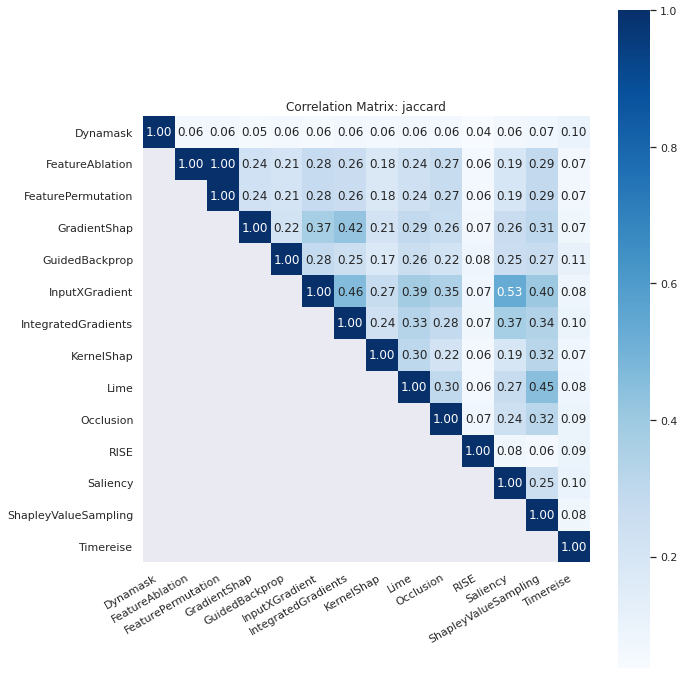

In [28]:
####### Compute correlation matrix #####
if options.compute_correlation_mat:
    for perc in np.fromstring(options.correlation_perc, sep=','):
        for corr in options.correlations.split(','):
            if perc < 100 and corr != 'jaccard':
                continue
            base_attr_corr_mat_pd = attrComparer.compute_corr_mat(
                key='B_', mode=corr, perc=perc)
            if options.save_dicts:
                base_attr_corr_mat_dict = base_attr_corr_mat_pd.to_dict()
                dict_path = os.path.join(
                    subset_folder, 'Correlation_Matrix_' + corr + '_perc-' + str(perc) + '_key-B.txt')
                utils.get_pretty_dict(
                    base_attr_corr_mat_dict, sort=True, save=dict_path if options.save_dicts else None, verbose=options.verbose)
            
            if options.save_plots or not options.not_show_plots:
                plotter.plot_correlation_matrix(
                    base_attr_corr_mat_pd, mode=corr, perc=perc, not_show=options.not_show_plots, 
                    save_path=subset_folder if options.save_plots else None)

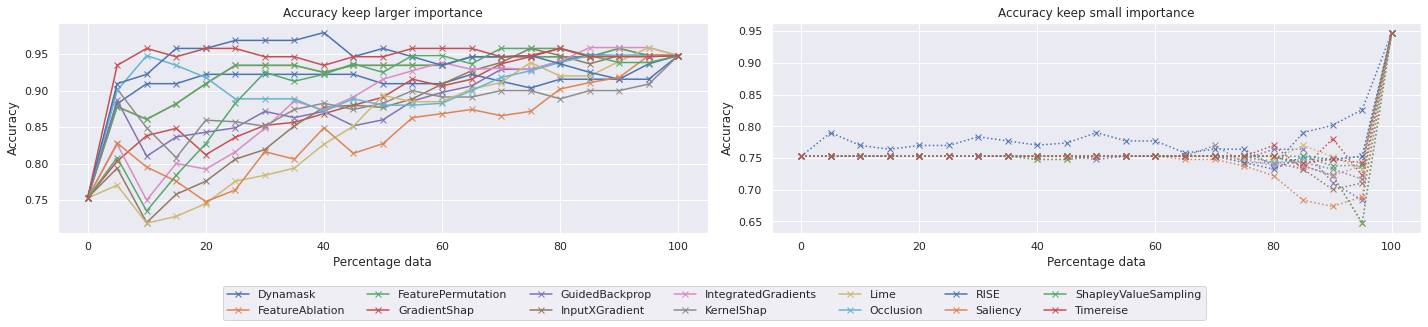

In [46]:
######### Compute modified_dict ########
if options.compute_modified_acc_dict:
    base_attr_names = [n for n in sorted(
        attrComparer.attributions) if 'B_' in n]
    pr = np.fromstring(options.compute_modified_acc_dict_ranges, sep=',')
    larger_dict, smaller_dict = np.arange(
        pr[0], pr[1], pr[2]), np.arange(pr[3], pr[4], pr[5])
    modified_acc_dict = attrComparer.compute_modified_acc_dict(
        model, sub_testX, sub_testY, base_attr_names, percs=[larger_dict, smaller_dict])

    if options.save_dicts:
        dict_path = os.path.join(
            subset_folder, 'Modified_Accuracies_Matrix.txt')
        utils.get_pretty_dict(
            modified_acc_dict, sort=True, save=dict_path if options.save_dicts else None, verbose=options.verbose)

    if options.save_plots or not options.not_show_plots:
        plotter.plot_masked_dict(
            modified_acc_dict, not_show=options.not_show_plots, save_path=subset_folder if options.save_plots else None)

Keep: larger | Test percentage: 1 | Methods left 14 / 14
Keep: larger | Test percentage: 2 | Methods left 14 / 14
Keep: larger | Test percentage: 3 | Methods left 14 / 14
Keep: larger | Test percentage: 4 | Methods left 14 / 14
Keep: larger | Test percentage: 5 | Methods left 14 / 14
Keep: larger | Test percentage: 6 | Methods left 14 / 14
Keep: larger | Test percentage: 7 | Methods left 14 / 14
Keep: larger | Test percentage: 8 | Methods left 14 / 14
Keep: larger | Test percentage: 9 | Methods left 14 / 14
Keep: larger | Test percentage: 10 | Methods left 14 / 14
Keep: larger | Test percentage: 11 | Methods left 14 / 14
Keep: larger | Test percentage: 12 | Methods left 14 / 14
Keep: larger | Test percentage: 13 | Methods left 14 / 14
Keep: larger | Test percentage: 14 | Methods left 14 / 14
Keep: larger | Test percentage: 15 | Methods left 14 / 14
Keep: larger | Test percentage: 16 | Methods left 14 / 14
Keep: larger | Test percentage: 17 | Methods left 14 / 14
Keep: larger | Test per

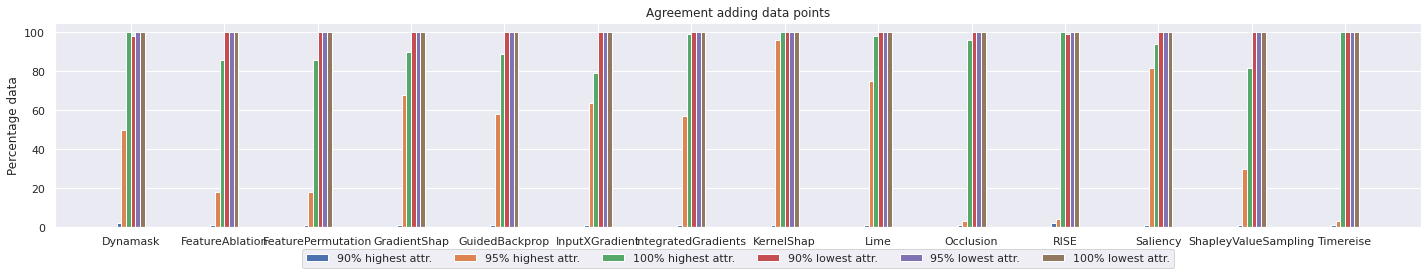

In [45]:
######## Compute required ratios ########
if options.compute_agreements:
    base_attr_names = [n for n in sorted(
        attrComparer.attributions) if 'B_' in n]
    agree = np.arange(*np.fromstring(options.agreement_percs, sep=','))
    agreement_dict = attrComparer.compute_agreement_dict(model, sub_testX, base_attr_names, agree, verbose=options.verbose)
    
    if options.save_dicts:
        dict_path = os.path.join(
            subset_folder, 'Modified_Agreement_Matrix.txt')
        utils.get_pretty_dict(
            agreement_dict, sort=True, save=dict_path if options.save_dicts else None, verbose=options.verbose)

    if options.save_plots or not options.not_show_plots:
        plotter.plot_agreements(
            agreement_dict, not_show=options.not_show_plots, save_path=subset_folder if options.save_plots else None)

In [28]:
###### Create mean eval report #########
if options.save_mcr:
    mean_report_path = os.path.join(result_dir, report_paths[0].replace('_run-0', '').replace('_report.txt', '_mean-report.txt'))
    mean_cr_utils.compute_meanclassification_report(report_paths, save=mean_report_path, verbose=options.verbose, store_dict=True)

In [29]:
######### Begin Not in py ###############